In [1]:
import sys
import os

project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.append(project_root)

%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from src.features import build_features
from src.visualization import visualize

sns.set_style()
plt.rcParams["figure.figsize"] = (12, 6)

DIAGS_RELEVANTES = [
    "C33X",
    "C340",
    "C341",
    "C342",
    "C343",
    "C381",
    "C384",
    "C450",
    "C780",
    "C782",
    "D143",
    "D381",
    "E848",
    "I080",
    "I081",
    "I340",
    "I350",
    "I351",
    "I352",
    "I420",
    "I456",
    "I472",
    "I495",
    "I710",
    "I712",
    "J398",
    "J47X",
    "J679",
    "J841",
    "J848",
    "J849",
    "J860",
    "J869",
    "J90X",
    "J91X",
    "J931",
    "J955",
    "J980",
    "M348",
    "Q211",
    "Q231",
    "Q676",
    "T820",
    "T821",
    "Z450",
]

DIAGS_FALTANTES_PULMON = ["C349", "C348"]

DIAGS_RELEVANTES += DIAGS_FALTANTES_PULMON

In [3]:
# Carga los egresos nacionales
egresos_nacionales = pd.read_csv(
    "../data/processed/ranking_nacional_egresos.csv", sep=";", encoding="latin-1"
)

# Filtra solamente los datos del INT
egresos_torax = egresos_nacionales.query("ESTABLECIMIENTO_SALUD == 112103").copy()

En primer lugar, se filtrarán ambas bases de datos para solamente tener la información de los diagnósticos más relevantes para el INT. Luego de esto, se calculará la cantidad de egresos, dias de estada y pacientes para cada uno de los diagnósticos. Estos insumos serán utilizados para estimar la demanda.

In [4]:
# Filtra solamente los diagnosticos mas relevantes del Torax
egresos_mas_relevantes_nacionales = (
    egresos_nacionales[egresos_nacionales["DIAG1"].isin(DIAGS_RELEVANTES)]
    .query("ANO_EGRESO >= 2017")
    .copy()
)

# Agrupa todos los diagnosticos relacionados a cancer de pulmon a un diagnostico comun
egresos_mas_relevantes_nacionales["DIAG1"] = egresos_mas_relevantes_nacionales["DIAG1"].replace(
    ["C340", "C341", "C342", "C343", "C348", "C349"], "C34"
)

# Filtra solamente los diagnosticos relevantes para el torax
egresos_mas_relevantes_torax = egresos_mas_relevantes_nacionales.query(
    "ESTABLECIMIENTO_SALUD == 112103"
).copy()

In [63]:
def calculate_metrics(df):
    metricas = pd.pivot_table(
        df,
        index="DIAG1",
        columns="ANO_EGRESO",
        values=["n_pacientes_distintos", "n_egresos", "dias_estada_totales"],
        aggfunc="sum",
        fill_value=0,
    ).sort_index()

    # Obtiene dias de estada promedio
    dias_estada_promedio = metricas["dias_estada_totales"] / metricas["n_egresos"]
    dias_estada_promedio.columns = [
        ("dias_estada_promedio", i) for i in dias_estada_promedio.columns
    ]

    # Obtiene egresos por paciente
    egresos_por_paciente = metricas["n_egresos"] / metricas["n_pacientes_distintos"]
    egresos_por_paciente.columns = [
        ("egresos_por_paciente", i) for i in egresos_por_paciente.columns
    ]

    metricas = pd.concat([metricas, dias_estada_promedio], axis=1)
    metricas = pd.concat([metricas, egresos_por_paciente], axis=1)

    return metricas

In [70]:
# Obtiene el resumen de metricas para el estrato nacional
metricas_diags_relevantes_nacionales = calculate_metrics(egresos_mas_relevantes_nacionales)

# Obtiene resumen de metricas para el Torax
metricas_diags_relevantes_torax = calculate_metrics(egresos_mas_relevantes_torax)

# Obtiene el porcentaje de resolucion de egresosx del Torax
porcentaje_egresos_nacionales_torax = (
    metricas_diags_relevantes_torax["n_egresos"] / metricas_diags_relevantes_nacionales["n_egresos"]
)

Una vez ya obtenido las metricas relevantes tanto para el estrato Nacional y del hospital a analizar, se procederá a comparar con los casos teóricos.

In [ ]:
# Importa los casos teoricos por cada problema de salud
casos_teoricos = pd.read_excel("../data/interim/casos_teoricos_diagnosticos.xlsx")
casos_teoricos["Diagnostico"] = casos_teoricos["Diagnostico"].str.split("-").str[0].str.strip()
casos_teoricos = casos_teoricos.set_index("Diagnostico")

# Obtiene los casos en el estrato nacional
casos_nacionales = casos_teoricos.query("Estrato == 'Pais' and Estadística == 'Incidencia'").copy()
casos_nacionales_del_2017_al_2020 = casos_nacionales[[f"Poblacion {i}" for i in range(2017, 2021)]]

In [ ]:
# Une la cantidad de casos teoricos y reales
union_de_pacientes_teoricos_y_vistos = casos_nacionales_del_2017_al_2020.merge(
    resumen_egresos_mas_relevantes_nacionales["n_pacientes_distintos"],
    how="left",
    left_index=True,
    right_index=True,
)

# Renombra las columnas
niveles_columnas = [
    ("poblacion_teorica", "2017"),
    ("poblacion_teorica", "2018"),
    ("poblacion_teorica", "2019"),
    ("poblacion_teorica", "2020"),
    ("poblacion_vista", "2017"),
    ("poblacion_vista", "2018"),
    ("poblacion_vista", "2019"),
    ("poblacion_vista", "2020"),
]

union_de_pacientes_teoricos_y_vistos.columns = pd.MultiIndex.from_tuples(niveles_columnas)

# Calcula la cantidad de cumplimiento de los casos teoricos
porcentaje_de_atencion_casos_teoricos = union_de_pacientes_teoricos_y_vistos["poblacion_vista"].sum(
    axis=1
) / union_de_pacientes_teoricos_y_vistos["poblacion_teorica"].sum(axis=1)

In [ ]:
proyeccion_de_casos_a_atender = casos_nacionales[[f"Poblacion {i}" for i in range(2017, 2036)]].mul(
    porcentaje_de_atencion_casos_teoricos, axis=0
)

In [ ]:
# Obtiene egresos por caso por diagnostico
egresos_por_persona_nacionales = resumen_egresos_mas_relevantes_nacionales["n_egresos"].sum(
    axis=1
) / resumen_egresos_mas_relevantes_nacionales["n_pacientes_distintos"].sum(axis=1)

# Obtiene dias de estada por egreso
dias_de_estada_por_egreso_nacionales = resumen_egresos_mas_relevantes_nacionales[
    "dias_estada_totales"
].sum(axis=1) / resumen_egresos_mas_relevantes_nacionales["n_egresos"].sum(axis=1)

# Obtiene porcentaje de atendimiento del torax de egresos nacionales
porcentaje_de_atendimiento_torax = resumen_egresos_mas_relevantes_torax["n_egresos"].sum(
    axis=1
) / resumen_egresos_mas_relevantes_nacionales["n_egresos"].sum(axis=1)

# Obtiene dias de estada por egresos
dias_de_estada_por_egreso_torax = resumen_egresos_mas_relevantes_torax["dias_estada_totales"].sum(
    axis=1
) / resumen_egresos_mas_relevantes_torax["n_egresos"].sum(axis=1)

In [ ]:
# Obtiene la cantidad de egresos, dias de estada y camas por la proyeccion
proyeccion_de_egresos_nacionales = proyeccion_de_casos_a_atender.mul(
    egresos_por_persona_nacionales, axis=0
)
proyeccion_de_egresos_int = proyeccion_de_egresos_nacionales.mul(
    porcentaje_de_atendimiento_torax, axis=0
)
proyeccion_de_dias_de_estada_int = proyeccion_de_egresos_int.mul(
    dias_de_estada_por_egreso_torax, axis=0
)
proyeccion_de_camas_a_tener_int = proyeccion_de_dias_de_estada_int / 365.25

<Axes: >

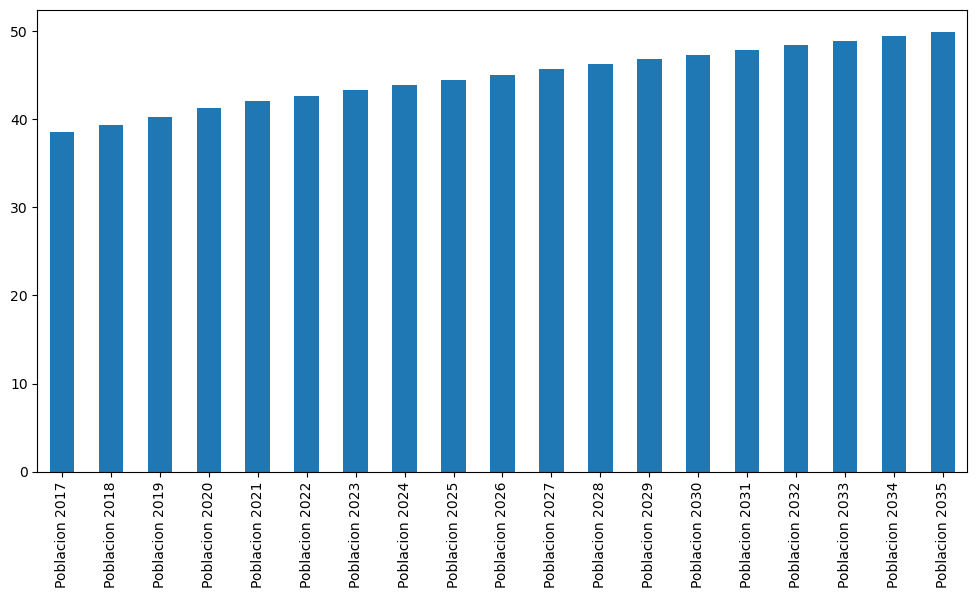

In [ ]:
proyeccion_de_camas_a_tener_int.sum().plot(kind="bar")